# About this Notebook
Given the size of both the various embeddings, the datasets (including multiple 'noise'<sup> 1 </sup> test sets), I have created several smaller embedding dedicated notebooks that can be run seperately that allow us to run without reducing embedding sizes or sampling.<br>
<br>

**This notebook is dedicated to only the -unreduced- 300 dim FastText embedding method**
<br>
<br>

All classifcation models from the main notebook are used:  

- Logistic Regression (LR)
- Naive Bayes (NB)
- Random Forest (RF)
- Support Vector Machine (SVM)
- K-Nearest Neighbour (KNN)
- GradientBoosting (GB)
- Extreme Gradient Boosting (XGB)   
  
<br>


---


  
  

<sup>1  </sup>*Noise levels as introduced by machine backtranslations. 'N0' being the original testset (the version similar to training), 'N1' (1 level of backtranslation (EN -> RU -> EN), continuing to 'N3'.
For rough assessment of noise in a purely lexical sense, the Jaro-Winkler Distances (normalized) have been calculated and imported before and are imported in this notebook*. 
<br>
<br>



# Import + mounting drive

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.csc import csc_matrix
import matplotlib.pyplot as plt

#preprocessing:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MaxAbsScaler
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences #or: from tensorflow.keras.preprocessing.sequence import pad_sequences
#nltk

#pickle:
from pickle import dump, load
picklepath = '/content/drive/MyDrive/MYDATA/PickledModels/Dedicated/'

#classifiers:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

#evaluation
from sklearn.metrics import roc_auc_score


#system:
import gc
import sys
from google.colab import drive
import gzip

<ipython-input-1-8e9ca7140445>:3: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.csc import csc_matrix


In [2]:
#from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#no need to run this everytime

#!pip install pipreqs
#!pipreqs . 

In [4]:
# this colab builds on the FULL_CREATION_DataSet.ipynb colab
# link: https://colab.research.google.com/drive/1lFMu0WaWkpDCZpPCH3eC3LJWlYNlbg06?usp=sharing
# this previous colab exports the seperate train and test sets..

# Reading in test & train sets (csv method)




In [5]:
pathTESTcsv = '/content/drive/MyDrive/MYDATA/DATA/full_TEST_Nx_stemmed.csv' #be mindful, this is Test-INC (as the INC is the one with the translation columns)
pathTRAINcsv = '/content/drive/MyDrive/MYDATA/DATA/full_TRAIN_stemmed.csv' #NTS: this trainset is not capped at 2800 chars.. (the testset is..)

df_test = pd.read_csv(pathTESTcsv)
df_train = pd.read_csv(pathTRAINcsv)

In [6]:
#BE AWARE:
#df_train = df_train.sample(10000, random_state=42) #smaller for faster testing..

In [7]:
len(df_test[df_test['text_N1'].str.contains('д|и|г')]) #how many rows are not translated back to english correctly? # ±30%..
# redo preceeding colab, but with more rigorous cleaning (en see if thats helps), if not, redo with other languaage than russian.

561

# Embedding 0: Assigning the series needed for embedding


*   X_train
*   y_train
*   X_testNx (for N0 to N3)
*   y_test (same for all N's)

In [8]:
X_train = df_train['text']
y_train = df_train['label']
X_testN0 = df_test['text']
X_testN1 = df_test['text_N1']
X_testN2 = df_test['text_N2']
X_testN3 = df_test['text_N3']
y_testALL = df_test['label']

In [9]:
#X_train[:10]
X_train.shape

(51331,)

# Prepping for pretraind embeddings
- fasttext

In [10]:
word_tokenizer = Tokenizer(num_words = 1000)
word_tokenizer.fit_on_texts(X_train)

word_index = word_tokenizer.word_index
vocab_length = len(word_index) + 1 #cant be unique words recheck this. Probably need cleaning of data first so that e.g. @CNN is not counted as unique word
# https://github.com/keras-team/keras/issues/7551
#vocab_length -> 267981 / 231677

In [11]:
#list(word_index)[-300:]

#as I thought, the vocab can be made lot shorter by:
# - cleaning data (removing " before tokenizing)
# - removing @mentions or somehting (perhaps just remove everything immediately following @?)

In [12]:
print(word_index.get('trump'))
# so this dictionary (word_index) has the vocab (267981 words..) stored sort of in order of usage ('the' is 1, 'a' is 4)

15


In [13]:
#convert series to list (prior to this 2.7GB used)
X_train_sequences = word_tokenizer.texts_to_sequences(X_train)
# ---
X_testN0_sequences = word_tokenizer.texts_to_sequences(X_testN0)
X_testN1_sequences = word_tokenizer.texts_to_sequences(X_testN1)
X_testN2_sequences = word_tokenizer.texts_to_sequences(X_testN2)
X_testN3_sequences = word_tokenizer.texts_to_sequences(X_testN3)

In [14]:
# Output the results to inspect what is happening
print("Word index for example word 'home' :\n", word_index.get('home')) #chosen as it is the 1st word in X_train 1st doc
print("\nTraining sequence of first doc:\n", X_train_sequences[0]) #first doc, starting with word 'home'
print("\nX_train_sequences data type:", type(X_train_sequences))

Word index for example word 'home' :
 310

Training sequence of first doc:
 [211, 635, 175, 785, 692, 23, 16, 219, 251, 279, 1, 54, 8, 170, 74, 25, 1, 742, 167, 23, 189, 735, 641, 12, 18, 4, 627, 204, 90, 129, 64, 46, 1, 119, 86, 6, 1, 1, 742, 124, 343, 29, 1, 2, 1, 5, 1, 163, 46, 373, 100, 1, 74, 80, 5, 588, 921, 626, 64, 21, 4, 627, 5, 921, 212, 115, 62, 51, 166, 782, 9, 1, 3, 4, 64, 288, 5, 172, 51, 840, 90, 1, 3, 33, 546, 153, 325, 3, 1, 345, 13, 8, 177, 97, 129, 64, 13, 8, 3, 868, 9, 551, 5, 232, 277, 27, 144, 21, 4, 2, 245, 36, 12, 277, 2, 133, 49, 274, 1, 167, 919, 3, 31, 2, 1, 116, 21, 23, 1, 345, 798, 82, 4, 793, 11, 1, 3, 338, 163, 31, 2, 730, 45, 5, 7, 68, 10, 106, 4, 19, 936, 20, 3, 4, 15, 288, 683, 21, 1, 74, 6, 54, 8, 526, 225, 2, 1, 114, 187, 7, 162, 2, 22, 652, 10, 1, 3, 33, 325, 962, 23, 94, 67, 12, 144, 2, 1, 463, 618, 28, 74, 1, 451, 187, 185, 3, 552, 10, 51, 3, 72, 233, 1, 237, 3, 28, 74, 1, 192, 25, 47, 7, 64, 41, 288, 94, 878, 7, 15, 43, 27, 22, 662, 2, 16, 1, 163

In [15]:
# Get max training sequence length
maxlenCalc = max([len(x) for x in X_train_sequences])
print(maxlenCalc)

558


In [16]:
#set some restrictive limits to make it fast for now
#max_features = 500
max_len = 80 #replace with: maxlenCalc = max([len(x) for x in X_train_sequences])
              #or replace with desired length of dim divided by 50 (length of vectors per word)
              #For now limited to a mere 80 to save RAM in order to fit all in a single 35GB RAM environment
padding_type='post'
truncation_type='post'

In [17]:
#padding or truncating the lists (sequences) to make equal length. Now Numpy Arrays
# replace with maxlenCalc (887), but keep at 300 for now for speed..
X_train_SeqPad = pad_sequences(X_train_sequences, maxlen=max_len, padding=padding_type, truncating=truncation_type)
# ---
X_testN0_SeqPad = pad_sequences(X_testN0_sequences, maxlen=max_len, padding=padding_type, truncating=truncation_type)
X_testN1_SeqPad = pad_sequences(X_testN1_sequences, maxlen=max_len, padding=padding_type, truncating=truncation_type)
X_testN2_SeqPad = pad_sequences(X_testN2_sequences, maxlen=max_len, padding=padding_type, truncating=truncation_type)
X_testN3_SeqPad = pad_sequences(X_testN3_sequences, maxlen=max_len, padding=padding_type, truncating=truncation_type)

#after this block: 3.0gb

In [18]:
# Output the results to inspect what is happening
print("\nPadded training sequences of first doc:\n", X_train_SeqPad[0])
print("\nX_train_SeqPad data type:", type(X_train_SeqPad))
print("\nX_train_SeqPad shape:", X_train_SeqPad.shape) #rows (67625) by maxlen (110)


Padded training sequences of first doc:
 [211 635 175 785 692  23  16 219 251 279   1  54   8 170  74  25   1 742
 167  23 189 735 641  12  18   4 627 204  90 129  64  46   1 119  86   6
   1   1 742 124 343  29   1   2   1   5   1 163  46 373 100   1  74  80
   5 588 921 626  64  21   4 627   5 921 212 115  62  51 166 782   9   1
   3   4  64 288   5 172  51 840]

X_train_SeqPad data type: <class 'numpy.ndarray'>

X_train_SeqPad shape: (51331, 80)


# Embedding 6: FastText

In [19]:
#EMBEDDING_INDEX
#Creating the.... Embedding Index (aka embedding dictionary)

embedding_dim = 50 #based on ...file..  ('...50d.txt')
embeddings_index = {} # == 'embeddings_dictionary'

with gzip.open('/content/drive/MyDrive/MYDATA/Embeddings_PreTrained/FastText/FastText_PCA_reduced-vectors.txt.gz', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0].decode('utf-8')
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


print(f'Found {len(embeddings_index)} word vectors.')

Found 999994 word vectors.


In [20]:
#EMBEDDING_MATRIX
#this is where we need to grab each word from the padded sequences and match them with the embeddings index to create the embedding_matrix
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, embedding in word_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[embedding] = embedding_vector
        
#embedding_matrix #numpy array

In [21]:
# replacing the above 5 blocks:
# For GloVe this block took about 10 GB

def embedding_generator(X, embedding_matrix):
    for x in X:
        yield embedding_matrix[x]

# training set
nparraylist_train = np.array(list(embedding_generator(X_train_SeqPad, embedding_matrix)))

# test sets
test_sets = [X_testN0_SeqPad, X_testN1_SeqPad, X_testN2_SeqPad, X_testN3_SeqPad]
nparraylist_tests = []
for X_test in test_sets:
    nparraylist_tests.append(np.array(list(embedding_generator(X_test, embedding_matrix))))

# reshape arrays
dims = (len(nparraylist_train), len(nparraylist_train[0]) * len(nparraylist_train[0][0]))
X_train_ft = np.reshape(nparraylist_train, dims)

X_tests_ft = []
for nparraylist_test in nparraylist_tests:
    dims = (len(nparraylist_test), len(nparraylist_test[0]) * len(nparraylist_test[0][0]))
    X_tests_ft.append(np.reshape(nparraylist_test, dims))

X_testN0_ft, X_testN1_ft, X_testN2_ft, X_testN3_ft = X_tests_ft

In [22]:
#THIS BLOCK IS ONLY FOR THE NAIVE BAYES CLASSIFIER

#scaling
#minmax would be the go to for sparse data, however our sparse data contains negative values -> MaxAbsScaler
#from sklearn.preprocessing import MaxAbsScaler
#THis takes another 10GB...

MaxAbs_scaler = MaxAbsScaler()

# transform data
# (check whether indeed best to fit scaler only on trainset)
MaxAbs_scaler.fit(X_train_ft)
X_train_ft_scaled = MaxAbs_scaler.transform(X_train_ft)
X_testN0_ft_scaled = MaxAbs_scaler.transform(X_testN0_ft)
X_testN1_ft_scaled = MaxAbs_scaler.transform(X_testN1_ft)
X_testN2_ft_scaled = MaxAbs_scaler.transform(X_testN2_ft)
X_testN3_ft_scaled = MaxAbs_scaler.transform(X_testN3_ft)

In [23]:
#shift +1 for all non-zero values to be usable for Naive Bayes classifier
#from scipy.sparse.csc import csc_matrix
X_train_ft_scaled += 1
X_testN0_ft_scaled += 1
X_testN1_ft_scaled += 1
X_testN2_ft_scaled += 1
X_testN3_ft_scaled += 1

In [24]:
nparraylist_train, nparraylist_test, nparraylist_testN0, nparraylist_testN1, nparraylist_testN2, nparraylist_testN3 = [], [], [], [], [], []
del nparraylist_train, nparraylist_testN0, nparraylist_testN1, nparraylist_testN2, nparraylist_testN3

In [25]:
gc.collect()

0

# Check RAM

In [26]:
# also see del statement under glove embedding code
# and the gc collect

In [27]:
#code snippet to list all self defined vars and their RAM uptake
#source: https://stackoverflow.com/questions/40993626/list-memory-usage-in-ipython-and-jupyter

#import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('X_train_ft_scaled', 1642592128),
 ('X_testN0_ft_scaled', 703968128),
 ('X_testN1_ft_scaled', 703968128),
 ('X_testN2_ft_scaled', 703968128),
 ('X_testN3_ft_scaled', 703968128),
 ('df_test', 223083096),
 ('df_train', 129940098),
 ('X_train', 129529450),
 ('X_testN1', 56058971),
 ('X_testN2', 55725511),
 ('X_testN3', 55598075),
 ('X_testN0', 55524979),
 ('embedding_matrix', 53963328),
 ('embeddings_index', 41943136),
 ('X_train_SeqPad', 16426048),
 ('X_test', 7039808),
 ('X_testN0_SeqPad', 7039808),
 ('X_testN1_SeqPad', 7039808),
 ('X_testN2_SeqPad', 7039808),
 ('X_testN3_SeqPad', 7039808),
 ('word_index', 5242968),
 ('X_train_sequences', 444376),
 ('y_train', 410792),
 ('X_testN0_sequences', 194680),
 ('X_testN1_sequences', 194680),
 ('X_testN2_sequences', 194680),
 ('X_testN3_sequences', 194680),
 ('y_testALL', 176136),
 ('Tokenizer', 1472),
 ('CountVectorizer', 1064),
 ('GradientBoostingClassifier', 1064),
 ('HashingVectorizer', 1064),
 ('KNeighborsClassifier', 1064),
 ('LogisticRe

# Model 0: Creating lists for iterative model comparisons.

In [28]:
ListTestsets_ft = [X_testN0_ft, X_testN1_ft, X_testN2_ft, X_testN3_ft]

ListTestsets_ft_scaled = [X_testN0_ft_scaled, X_testN1_ft_scaled, X_testN2_ft_scaled, X_testN3_ft_scaled]

names_list = ['X_testN0', 'X_testN1', 'X_testN2', 'X_testN3']

# Model 1: Logistics Regression

In [32]:
#from sklearn.linear_model import LogisticRegression
classifierLR = LogisticRegression(solver='lbfgs', max_iter=2000)

In [33]:
Model_LR_ft= classifierLR.fit(X_train_ft, y_train)
with open(picklepath+"Model_LR_ft.pkl", "wb") as f:
    dump(Model_LR_ft, f)

Comparing results Logistic regression with FastText.

(N0 (base), N1, N2 and N3)

In [34]:
with open(picklepath + 'Model_LR_ft.pkl', 'rb') as f:
  Model_LR_ft = load(f)
  score_test = Model_LR_ft.score(X_train_ft, y_train)
  print(f'Model overfit check (fasttext + LR): {score_test}') #.9966..
  for i, name in zip(ListTestsets_ft, names_list):
    y_pred = Model_LR_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_LR_ft.score(i, y_testALL)
    print(f'AUC score for fasttext + LogisticRegression on {name} (1%split): {score_test}')

Model overfit check (fasttext + LR): 0.8334339872591612
AUC score for fasttext + LogisticRegression on X_testN0 (1%split): 0.7920673965937425
AUC score for fasttext + LogisticRegression on X_testN1 (1%split): 0.7461632896016922
AUC score for fasttext + LogisticRegression on X_testN2 (1%split): 0.7443791521037657
AUC score for fasttext + LogisticRegression on X_testN3 (1%split): 0.7471860397547909


# Model 2: Naive Bayes

In [35]:
#why MultinomialNB instead of Gaussian? GaussianNN seemed to need dense matrix as input and that kept overloading RAM
#as train set is about 60k by 67k which is fine for sparse but giant in dense matrix (see code at the bottom with failed attempts to use .todense function).
#from sklearn.naive_bayes import MultinomialNB
classifierNB = MultinomialNB()

In [36]:
Model_NB_ft = classifierNB.fit(X_train_ft_scaled, y_train, sample_weight=None)
with open(picklepath+"Model_NB_ft.pkl", "wb") as f:
    dump(Model_NB_ft, f)

Comparing results Naive Bayes with FastText.

(N0 (base), N1, N2 and N3)

In [37]:
with open(picklepath + 'Model_NB_ft.pkl', 'rb') as f:
  Model_NB_ft = load(f)
  score_test = Model_NB_ft.score(X_train_ft_scaled, y_train)
  print(f'Model overfit check (FastText + NB): {score_test}')
  for i, name in zip(ListTestsets_ft_scaled, names_list):
    y_pred = Model_NB_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_NB_ft.score(i, y_testALL)
    print(f'AUC score for FastText + Naive Bayes on {name} (1%split): {score_test}')

Model overfit check (FastText + NB): 0.5730065652334846
AUC score for FastText + Naive Bayes on X_testN0 (1%split): 0.5607380922829437
AUC score for FastText + Naive Bayes on X_testN1 (1%split): 0.5409161589079908
AUC score for FastText + Naive Bayes on X_testN2 (1%split): 0.5408063037456045
AUC score for FastText + Naive Bayes on X_testN3 (1%split): 0.5410163684937748


# Model 3: Random Forest




In [38]:
#from sklearn.ensemble import RandomForestClassifier
classifierRF = RandomForestClassifier(n_estimators= 20)

In [39]:
Model_RF_ft = classifierRF.fit(X_train_ft, y_train)
with open(picklepath+"Model_RF_ft.pkl", "wb") as f:
    dump(Model_RF_ft, f)

Comparing results Random Forest with FastText. 

- (N0 (base), N1, N2 and N3)

In [40]:
with open(picklepath + 'Model_RF_ft.pkl', 'rb') as f:
  Model_RF_ft = load(f)
  score_test = Model_RF_ft.score(X_train_ft, y_train)
  print(f'Model overfit check (ft + RF): {score_test}') #.9994..
  for i, name in zip(ListTestsets_ft, names_list):
    y_pred = Model_RF_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_RF_ft.score(i, y_testALL)
    print(f'AUC score for ft + Random Forest on {name} (1%split): {score_test}')

Model overfit check (ft + RF): 0.998655783055074
AUC score for ft + Random Forest on X_testN0 (1%split): 0.7350060796135617
AUC score for ft + Random Forest on X_testN1 (1%split): 0.6670657330632417
AUC score for ft + Random Forest on X_testN2 (1%split): 0.6619795558855014
AUC score for ft + Random Forest on X_testN3 (1%split): 0.6625622514658501


# Model 4: SupportVectorMachine

In [41]:
#from sklearn.linear_model import SGDClassifier
classifierSVM = SGDClassifier(loss='hinge', penalty='l2', random_state=42)

In [42]:
Model_SVM_ft = classifierSVM.fit(X_train_ft, y_train)
with open(picklepath+"Model_SVM_ft.pkl", "wb") as f:
    dump(Model_SVM_ft, f)

Comparing results SVM with FastText. 

- (N0 (base), N1, N2 and N3)

In [43]:
with open(picklepath + 'Model_SVM_ft.pkl', 'rb') as f:
  Model_SVM_ft = load(f)
  score_test = Model_SVM_ft.score(X_train_ft, y_train)
  print(f'Model overfit check (ft + SVM): {score_test}') #.7574..
  for i, name in zip(ListTestsets_ft, names_list):
    y_pred = Model_SVM_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_SVM_ft.score(i, y_testALL)
    print(f'AUC score for FastText + SVM on {name} (1%split): {score_test}')

Model overfit check (ft + SVM): 0.8338041339541408
AUC score for FastText + SVM on X_testN0 (1%split): 0.785538435062208
AUC score for FastText + SVM on X_testN1 (1%split): 0.7505630522475859
AUC score for FastText + SVM on X_testN2 (1%split): 0.7470006234323969
AUC score for FastText + SVM on X_testN3 (1%split): 0.74931313799295


# Model 5: K NearestNeighbour (KNN)

In [44]:
classifierKNN = KNeighborsClassifier(n_neighbors=3)
#remember: training KNN is fast, scoring is slow and RAM intensive.
#also.. these have giant pickle models (.pkl's) so change parameters a bit here..

In [45]:
Model_KNN_ft = classifierKNN.fit(X_train_ft, y_train)
with open(picklepath+"Model_KNN_ft.pkl", "wb") as f:
    dump(Model_KNN_ft, f)

Comparing results KNN with FastText. 

- (N0 (base), N1, N2 and N3)

In [46]:
with open(picklepath + 'Model_KNN_ft.pkl', 'rb') as f:
  Model_KNN_ft = load(f)
  score_test = Model_KNN_ft.score(X_train_ft, y_train)
  print(f'Model overfit check (ft + KNN): {score_test}') #.7574..
  for i, name in zip(ListTestsets_ft, names_list):
    y_pred = Model_KNN_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_KNN_ft.score(i, y_testALL)
    print(f'AUC score for FastText + KNN on {name} (1%split): {score_test}')

Model overfit check (ft + KNN): 0.8186086380549765
AUC score for FastText + KNN on X_testN0 (1%split): 0.6039556037311411
AUC score for FastText + KNN on X_testN1 (1%split): 0.5723413521828893
AUC score for FastText + KNN on X_testN2 (1%split): 0.5711222267082072
AUC score for FastText + KNN on X_testN3 (1%split): 0.5744854544787702


# Model 6. GradientBoosting

In [47]:
#from sklearn.ensemble import GradientBoostingClassifier

In [48]:
classifierGB = GradientBoostingClassifier(learning_rate=0.3, max_depth=2)
#change from 0.1 to 0.2 to save time when testing.. (NOTE: takes long time still at .2..)

In [49]:
Model_GB_ft = classifierGB.fit(X_train_ft, y_train)
with open(picklepath+"Model_GB_ft.pkl", "wb") as f:
    dump(Model_GB_ft, f)

Comparing results GradientBoosting with FastText. 

- (N0 (base), N1, N2 and N3)

In [50]:
with open(picklepath + 'Model_GB_ft.pkl', 'rb') as f:
  Model_GB_ft = load(f)
  score_test = Model_GB_ft.score(X_train_ft, y_train)
  print(f'Model overfit check (ft + GB): {score_test}') #.7574..
  for i, name in zip(ListTestsets_ft, names_list):
    y_pred = Model_GB_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_GB_ft.score(i, y_testALL)
    print(f'AUC score for FastText + GB on {name} (1%split): {score_test}')

Model overfit check (ft + GB): 0.8033546979408155
AUC score for FastText + GB on X_testN0 (1%split): 0.7935360475002552
AUC score for FastText + GB on X_testN1 (1%split): 0.7421581752252902
AUC score for FastText + GB on X_testN2 (1%split): 0.7381722069869806
AUC score for FastText + GB on X_testN3 (1%split): 0.7401511122103901


# Model 7. XGBoost (extreme gradient boosting)

In [51]:
#from xgboost import XGBClassifier

In [52]:
classifierXGB = XGBClassifier(learning_rate=0.2, max_depth=2)

In [53]:
Model_XGB_ft = classifierXGB.fit(X_train_ft, y_train)
with open(picklepath+"Model_XGB_ft.pkl", "wb") as f:
    dump(Model_XGB_ft, f)

Comparing results XGB with FastText. 

- (N0 (base), N1, N2 and N3)

In [54]:
with open(picklepath + 'Model_XGB_ft.pkl', 'rb') as f:
  Model_XGB_ft = load(f)
  score_test = Model_XGB_ft.score(X_train_ft, y_train)
  print(f'Model overfit check (ft + XGB): {score_test}') #.7574..
  for i, name in zip(ListTestsets_ft, names_list):
    y_pred = Model_XGB_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_XGB_ft.score(i, y_testALL)
    print(f'AUC score for FastText + XGB on {name} (1%split): {score_test}')

Model overfit check (ft + XGB): 0.7843603280668602
AUC score for FastText + XGB on X_testN0 (1%split): 0.778665833291058
AUC score for FastText + XGB on X_testN1 (1%split): 0.7324145725503894
AUC score for FastText + XGB on X_testN2 (1%split): 0.7295702710004298
AUC score for FastText + XGB on X_testN3 (1%split): 0.7283543607179483


# Noise Proxy
- JaroWinkler (and Hamming) Distance as proxy for 'Noise'. 
- Calculated in separate notebook, imported from csv.

In [ ]:
pathJWdist = '/content/drive/MyDrive/MYDATA/LexicalDistanceJW.csv'
pathHamdist = '/content/drive/MyDrive/MYDATA/LexicalDistanceHAMMING.csv'

In [ ]:
df_JaroWinkler = pd.read_csv(pathJWdist)
df_Hamming = pd.read_csv(pathHamdist)

In [ ]:
#display(df_JaroWinkler.describe())

In [ ]:
#display(df_Hamming.describe())

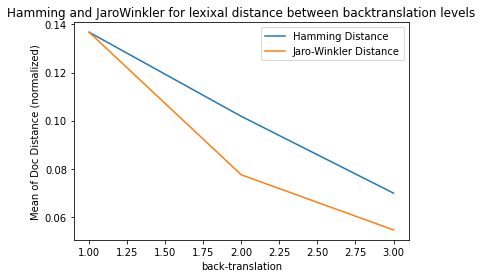

In [ ]:
#values taken from the describe method commented out above

# line 1 points
x1 = [1,2,3]
y1 = [0.136735,0.101772,0.069857]
# plotting the line 1 points 
plt.plot(x1, y1, label = "Hamming Distance")
# line 2 points
x2 = [1,2,3]
y2 = [0.136735,0.077469,0.054566]
# plotting the line 2 points 
plt.plot(x2, y2, label = "Jaro-Winkler Distance")
plt.xlabel('back-translation')
# Set the y axis label of the current axis.
plt.ylabel('Mean of Doc Distance (normalized)')
# Set a title of the current axes.
plt.title('Hamming and JaroWinkler for lexixal distance between backtranslation levels')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

# (Table)

In [ ]:
#total RAM (at 50dim, 80 maxlength, train at 20k, exlcuding KNN) is : 25.6GB
#total RAM (at 50dim, 80 maxlength, train at 20k, exlcuding KNN pretrained models) is : 27GB
#total RAM (at 50dim, 80 maxlength, train at 20k) is 29.5GB:

| Algorithm | Vectorizer | N0 | N1 | N2 | N3 |
| --- | --- | --- | --- | --- | --- |
| Logistic Regression | BoW | .843 | .843 |  .843 |  .843 |
| Logistic Regression | HV | .843 | .843 |  .843 |  .843 |
| Logistic Regression | TFIDF | .843 | .843 |  .843 |  .843 |
| Logistic Regression | GloVe | .843 | .843 |  .843 |  .843 |
| Logistic Regression | w2v | .843 | .843 |  .843 |  .843 |
| Logistic Regression | FastText | .843 | .843 |  .843 |  .843 |
| Naive Bayes | BoW | .843 | .843 |  .843 |  .843 |
| Naive Bayes | HV | .843 | .843 |  .843 |  .843 |
| Naive Bayes | TFIDF | .843 | .843 |  .843 |  .843 |
| Naive Bayes | GloVe | .843 | .843 |  .843 |  .843 |
| Naive Bayes | w2v | .843 | .843 |  .843 |  .843 |
| Naive Bayes | FastText | .843 | .843 |  .843 |  .843 |
| Random Forest | BoW | .843 | .843 |  .843 |  .843 |
| Random Forest | HV | .843 | .843 |  .843 |  .843 |
| Random Forest | TFIDF | .843 | .843 |  .843 |  .843 |
| Random Forest | GloVe | .843 | .843 |  .843 |  .843 |
| Random Forest | w2v | .843 | .843 |  .843 |  .843 |
| Random Forest | FastText | .843 | .843 |  .843 |  .843 |
| etc | etc | .843 | .843 |  .843 |  .843 |
